# Environment

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import divexplorer 
import pandas as pd
pd.set_option('max_colwidth', None)
import os
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from utils_analysis import filter_itemset_df_by_attributes, slice_by_itemset, \
    plot_true_pred, plotComparisonShapleyValues, plotMultipleSV, plotShapleyValue

In [3]:
## Define the minimum support threshold for data subgroups
min_sup = 0.03

# Util Functions

In [4]:
## Function for sorting data cohorts
def sortItemset(x, abbreviations={}):
    x = list(x)
    x.sort()
    x = ", ".join(x)
    for k, v in abbreviations.items():
        x = x.replace(k, v)
    return x

In [5]:
def attributes_in_itemset(itemset, attributes, alls = True):
    """ Check if attributes are in the itemset (all or at least one)
    
    Args:
        itemset (frozenset): the itemset
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        
    """
    # Avoid returning the empty itemset (i.e., info of entire dataset)
    if itemset == frozenset() and attributes:
        return False
    
    for item in itemset:
        # Get the attribute
        attr_i = item.split("=")[0]
        
        #If True, check if ALL attributes of the itemset are the input attributes.
        if alls:
            # Check if the attribute is present. If not, the itemset is not admitted
            if attr_i not in attributes:
                return False
        else:
            # Check if least one attribute. If yes, return True
            if attr_i in attributes:
                return True
    if alls:
        # All attributes of the itemset are indeed admitted
        return True
    else:
        # Otherwise, it means that we find None
        return False
    
def filter_itemset_df_by_attributes(df: pd.DataFrame, attributes: list, alls = True, itemset_col_name: str = "itemsets") -> pd.DataFrame:
    """Get the set of itemsets that have the attributes in the input list (all or at least one)
    
    Args:
        df (pd.DataFrame): the input itemsets (with their info). 
        attributes (list): list of itemset of interest
        alls (bool): If True, check if ALL attributes of the itemset are the input attributes. 
        If False, check AT LEAST one attribute of the itemset is in the input attributes.
        itemset_col_name (str) : the name of the itemset column, "itemsets" as default
        
    Returns:
        pd.DataFrame: the set of itemsets (with their info)
    """

    return df.loc[df[itemset_col_name].apply(lambda x: attributes_in_itemset(x, attributes, alls = alls))]

In [6]:
## Define abbreviations for plot and visualization
from divexplorer.FP_Divergence import abbreviateDict
abbreviations = { 
                  'Self-reported fluency level=native': 'fluency=native', \
                  'total_silence':'tot_silence', \
                  'location': 'loc', \
                  'Current language used for work/school=English (United States)': 'lang=EN_US', \
                  'ageRange': 'age', \
                  'speakerId' : 'spkID', \
                  'First Language spoken=English (United States)':  'lang=EN_US', \
                  'trimmed': 'trim', \
                  'total_': 'tot_', \
                  'speed_rate_word':'speakRate', \
                  'speed_rate_char':'speakCharRate', \
                  'change language': 'change lang', \
                  'duration': 'dur'
                }

abbreviations_shorter = abbreviations.copy()

In [7]:
n = 3  # Number of subgroups to visualize
K = 15  # Global Shapley values to visualize

# FSC

## Define targets

In [8]:
## Target for DivExplorer: 
# 'prediction' is 1 if predicted_intet == original_intent, 0 otherwise
target_col = 'prediction' 
target_metric = 'd_posr'
target_div = 'd_accuracy'
t_value_col = 't_value_tp_fn'

In [9]:
## Columns for visualization
show_cols = ['support', 'itemsets', '#errors', '#corrects', 'accuracy', \
                'd_accuracy', 't_value', 'support_count', 'length']
remapped_cols = {'tn': '#errors', 'tp': '#corrects', 'posr': 'accuracy', \
                target_metric: target_div, 't_value_tp_fn': 't_value'}

In [10]:
## Columns of the df file that we are going to analyze 
demo_cols = ['Self-reported fluency level ', 'First Language spoken',
       'Current language used for work/school', 'gender', 'ageRange']

slot_cols = ['action', 'object', 'location']

signal_cols = ['total_silence', 'total_duration', 'trimmed_duration', 
       'n_words', 'speed_rate_word', 'speed_rate_word_trimmed'] 

input_cols = demo_cols + slot_cols + signal_cols 

## Retrieve Data and Compute Divergence

In [11]:
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.FP_Divergence import FP_Divergence

In [12]:
configs = ["wav2vec2-base", "wav2vec2-large", "hubert-base", \
    "hubert-large", "wav2vec2-large-xlsr-53", "wav2vec2-xlsr-300m"]

FP_fm_dict = {}
fp_divergence_dict = {}
df_dict = {}

for config in configs:

    print(config)

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "FSC", f"FSC_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0 )
    df[target_col] = df[target_col]

    ## Add SpeakerID information if it is present in the df
    if "speakerId" in input_cols:
        df['speakerId'] = df.index.map(lambda x: x.split("/")[2])

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )

    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)
        
    df_discretized.loc[df_discretized["location"]=="none_location", "location"] = "none"
    df_discretized.loc[df_discretized["object"]=="none_object", "object"] = "none"
    
    ## Create dict of Divergence df
    df_dict[config] = df_discretized
    fp_diver = FP_DivergenceExplorer(df_discretized, true_class_name = target_col, class_map={"P":1, "N":0})
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])
    FP_fm.rename(columns = remapped_cols, inplace = True)
    FP_fm = FP_fm[show_cols].copy()
    FP_fm['accuracy'] = round(FP_fm['accuracy'], 5)
    FP_fm['d_accuracy'] = round(FP_fm['d_accuracy'], 5)
    FP_fm['t_value'] = round(FP_fm['t_value'], 2)
    FP_fm_dict[config] = FP_fm
    fp_divergence_dict[config] = FP_Divergence(FP_fm, target_div)

wav2vec2-base


wav2vec2-large
hubert-base
hubert-large
wav2vec2-large-xlsr-53
wav2vec2-xlsr-300m


In [13]:
## Compute the accuracy of the models
for config in configs:
    prediction = df_dict[config]['prediction'].sum()/len(df_dict[config])
    print(f"Accuracy of {config}:", round(100*prediction,3))
    print("----------")

Accuracy of wav2vec2-base: 91.722
----------
Accuracy of wav2vec2-large: 93.172
----------
Accuracy of hubert-base: 98.418
----------
Accuracy of hubert-large: 98.497
----------
Accuracy of wav2vec2-large-xlsr-53: 90.079
----------
Accuracy of wav2vec2-xlsr-300m: 98.338
----------


In [14]:
W2V2_BASE_ACC = 91.722
W2V2_LARGE_ACC = 93.172
HUBERT_BASE_ACC = 98.418
HUBERT_LARGE_ACC = 98.497
XLSR_53_ACC = 90.079
XLSR_128_ACC = 98.338

## Divergence Wav2Vec2-Base

In [15]:
## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]

In [16]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
44217,"age=22-40, gender=male, loc=none, speakRate=high, tot_silence=high",0.03,60.504,-31.217,7.05
32246,"age=22-40, gender=male, speakRate=high, tot_silence=high",0.04,62.857,-28.864,7.13
39743,"gender=male, loc=none, n_words=low, tot_silence=high, trim_dur=low",0.03,64.000,-27.722,6.54


,itemsets,support,accuracy,d_accuracy,t_value
30952,"gender=male, object=heat, tot_silence=low, trim_dur=high",0.04,100.0,8.278,9.30
30478,"gender=male, n_words=high, object=heat, tot_silence=low",0.04,100.0,8.278,9.35
27435,"age=22-40, loc=washroom, speakRate=low, trim_dur=high",0.04,100.0,8.278,9.74


,itemsets,support,accuracy,d_accuracy,t_value
114,(trimmed_duration=low),0.34,83.843,-7.878,7.04


,itemsets,support,accuracy,d_accuracy,t_value
3197,(action=change language),0.11,98.039,6.318,7.18


/home/akoudounas/miniconda3/envs/speech/lib/python3.10/site-packages/fontTools/misc/py23.py:11: DeprecationWarning: The py23 module has been deprecated and will be removed in a future release. Please update your code.
  warnings.warn(


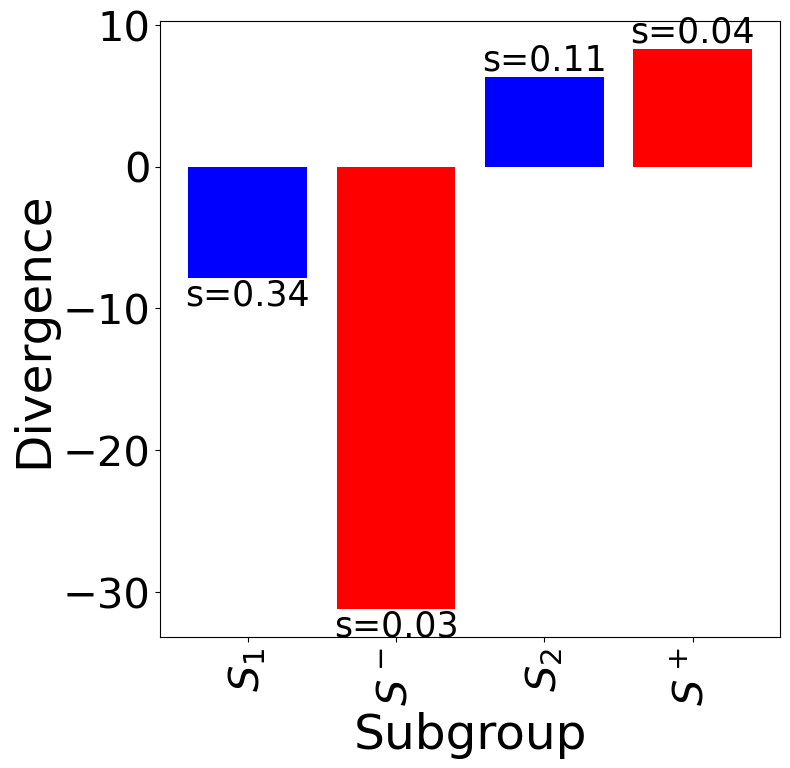

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("FSC, w2v2-b", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/FSC/fsc_baseline_wav2vec2-base.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence Wav2Vec2-Large

In [18]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [19]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
44217,"age=22-40, gender=male, loc=none, speakRate=high, tot_silence=high",0.03,74.790,-18.382,4.72
37151,"action=increase, gender=male, speakRate=high",0.03,74.809,-18.362,4.94
27745,"action=activate, gender=male, speakRate_trim=low",0.04,74.834,-18.337,5.27


,itemsets,support,accuracy,d_accuracy,t_value
21968,"action=change lang, age=41-65",0.04,100.0,6.828,8.85
13801,"action=change lang, gender=female",0.06,100.0,6.828,10.36
9230,"action=change lang, speakRate_trim=high",0.07,100.0,6.828,11.59


,itemsets,support,accuracy,d_accuracy,t_value
992,(action=activate),0.17,85.671,-7.5,5.33


,itemsets,support,accuracy,d_accuracy,t_value
24617,(object=none),0.04,100.0,6.828,8.45


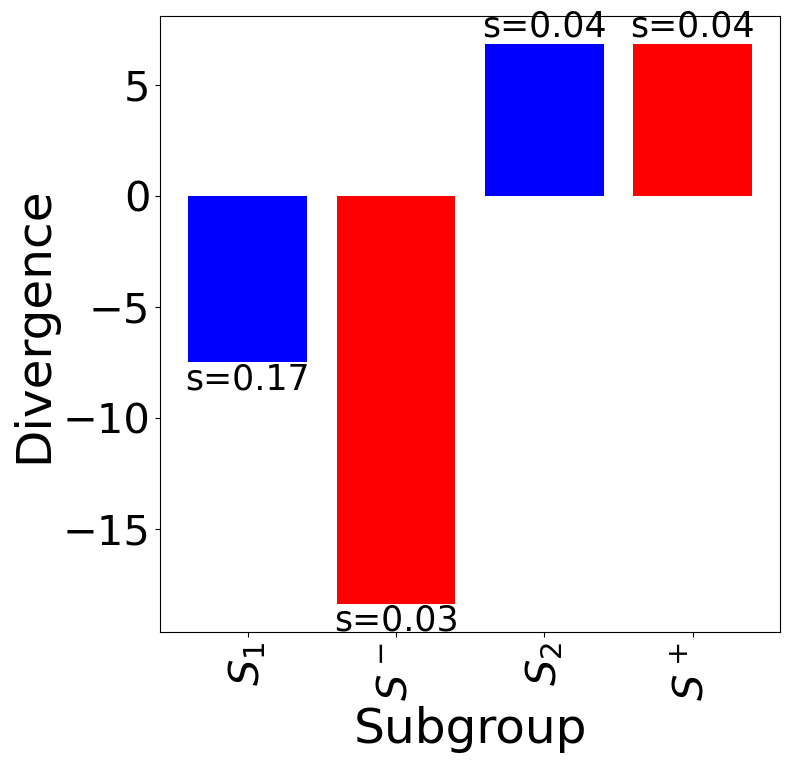

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("FSC, w2v2-l", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/FSC/fsc_baseline_wav2vec2-large.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence Wav2Vec2-XLSR-53-Large

In [21]:
## Compute the divergence for wav2vec 2.0 xlsr-53 large (300m)
config = 'wav2vec2-large-xlsr-53'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [22]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
43710,"action=increase, object=heat, speakRate_trim=medium, trim_dur=high",0.03,40.833,-49.246,11.00
41775,"action=increase, n_words=high, speakRate_trim=medium",0.03,40.984,-49.096,11.05
31317,"action=increase, speakRate_trim=medium, trim_dur=high",0.04,49.296,-40.783,9.75


,itemsets,support,accuracy,d_accuracy,t_value
11107,"age=22-40, object=lights, trim_dur=medium",0.06,100.0,9.921,14.94
10402,"gender=female, object=lights, tot_dur=high",0.07,100.0,9.921,15.19
8273,"object=lights, tot_dur=high, tot_silence=high",0.07,100.0,9.921,15.80


,itemsets,support,accuracy,d_accuracy,t_value
280,(action=increase),0.26,79.381,-10.698,7.75


,itemsets,support,accuracy,d_accuracy,t_value
30138,(object=lamp),0.04,100.0,9.921,11.07


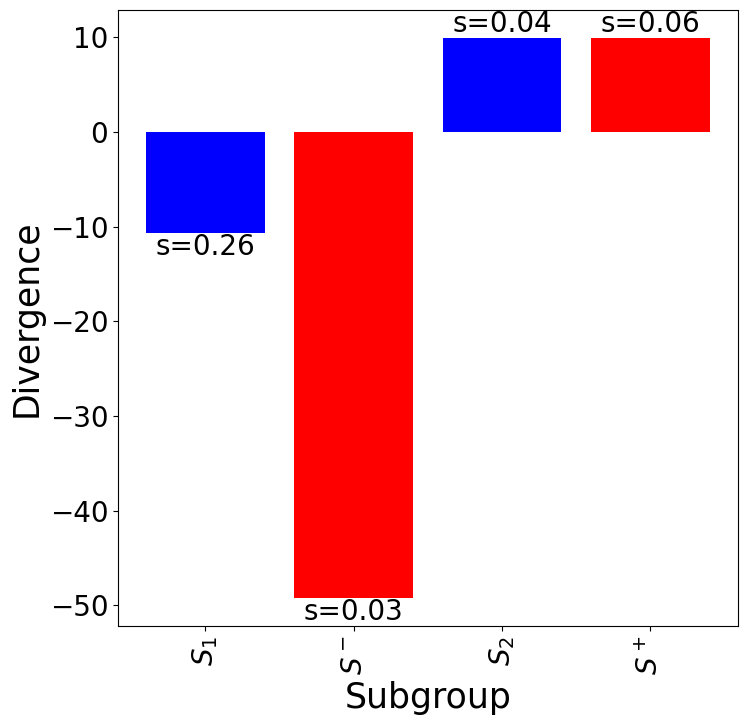

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=20)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=25)
plt.ylabel("Divergence", fontsize=25)
# plt.title("FSC, XLSR-53", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=20)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

# plt.savefig('plot_results/FSC/fsc_baseline_xlsr53.pdf', 
#     bbox_inches='tight', 
#     facecolor="white", 
#     transparent=False)
plt.show()

## Divergence Wav2Vec2-XLSR-128-300m

In [24]:
## Compute the divergence for wav2vec 2.0 xlsr-128 large (300m)
config = 'wav2vec2-xlsr-300m'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [25]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
46287,"age=22-40, n_words=high, object=heat, speakRate=low, speakRate_trim=medium",0.03,92.241,-6.096,2.65
45415,"age=22-40, gender=male, n_words=high, speakRate=low, speakRate_trim=medium",0.03,92.308,-6.030,2.64
33617,"gender=male, n_words=high, speakRate=low, speakRate_trim=medium",0.04,92.701,-5.637,2.72


,itemsets,support,accuracy,d_accuracy,t_value
4419,"age=22-40, loc=none, tot_dur=high",0.09,100.0,1.662,4.05
4284,"n_words=medium, tot_dur=high, tot_silence=high",0.10,100.0,1.662,4.09
3871,"gender=female, speakRate_trim=medium, tot_dur=high",0.10,100.0,1.662,4.24


,itemsets,support,accuracy,d_accuracy,t_value
235,(object=heat),0.3,97.171,-1.167,2.26


,itemsets,support,accuracy,d_accuracy,t_value
24662,(object=none),0.04,100.0,1.662,1.65


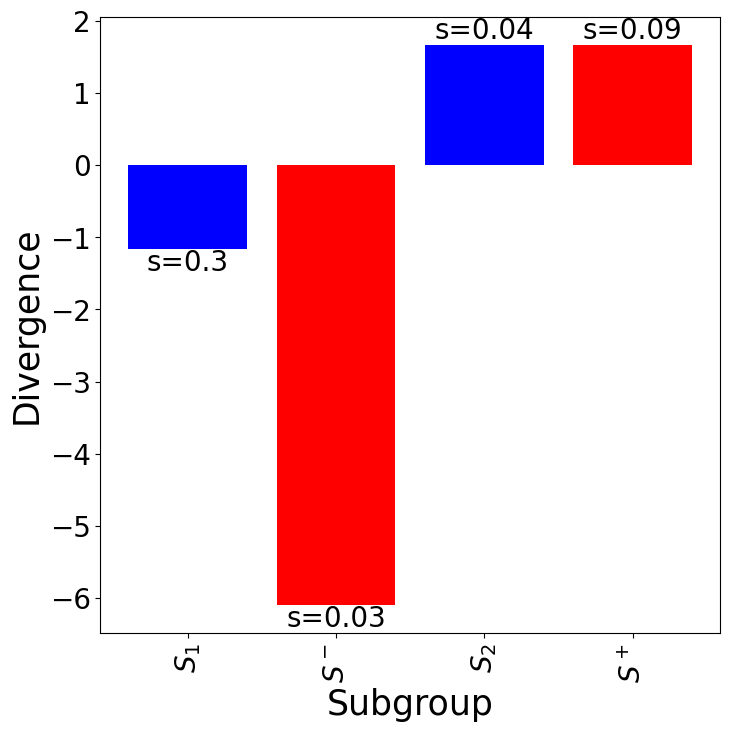

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=20)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=25)
plt.ylabel("Divergence", fontsize=25)
# plt.title("FSC, XLSR-128", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=20)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

# plt.savefig('plot_results/FSC/fsc_baseline_xlsr128.pdf', 
#     bbox_inches='tight', 
#     facecolor="white", 
#     transparent=False)
plt.show()

## Divergence HuBERT-Base

In [27]:
## Compute the divergence for HuBERT base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [28]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
41759,"age=22-40, gender=male, n_words=medium, tot_silence=high",0.03,89.344,-9.074,3.41
44217,"age=22-40, gender=male, loc=none, speakRate=high, tot_silence=high",0.03,89.916,-8.502,3.25
42367,"age=22-40, gender=male, loc=none, object=heat",0.03,90.083,-8.335,3.24


,itemsets,support,accuracy,d_accuracy,t_value
3394,"loc=none, speakRate_trim=high, trim_dur=medium",0.10,100.0,1.582,4.21
3197,action=change lang,0.11,100.0,1.582,4.29
3005,"tot_silence=medium, trim_dur=medium",0.11,100.0,1.582,4.39


,itemsets,support,accuracy,d_accuracy,t_value
234,(object=heat),0.3,97.44,-0.978,2.0


,itemsets,support,accuracy,d_accuracy,t_value
3197,(action=change language),0.11,100.0,1.582,4.29


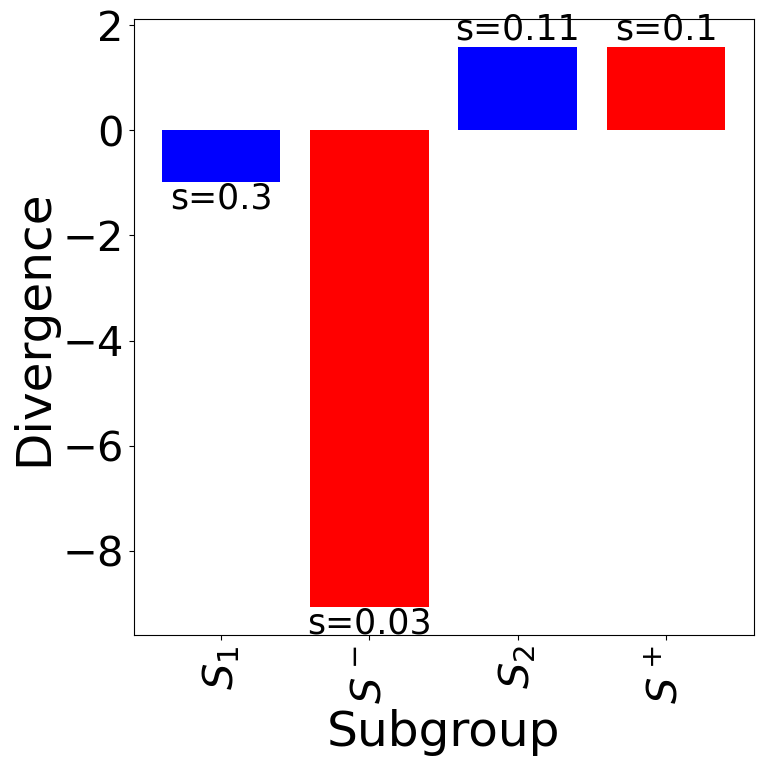

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("FSC, hub-b", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/FSC/fsc_baseline_hubert-base.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence HuBERT-Large

In [30]:
## Compute the divergence for HuBERT large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [31]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
31714,"speakRate=low, speakRate_trim=low, tot_silence=low, trim_dur=low",0.04,86.525,-11.972,4.30
35295,"loc=none, speakRate=low, speakRate_trim=low, tot_silence=low, trim_dur=low",0.04,87.313,-11.184,4.03
27706,"speakRate=low, tot_silence=low, trim_dur=low",0.04,87.500,-10.997,4.23


,itemsets,support,accuracy,d_accuracy,t_value
2553,"speakRate=medium, tot_silence=medium",0.12,100.0,1.503,4.36
2024,"speakRate=medium, tot_dur=high",0.13,100.0,1.503,4.64
1144,"gender=female, tot_dur=high, trim_dur=high",0.16,100.0,1.503,5.35


,itemsets,support,accuracy,d_accuracy,t_value
12466,(object=music),0.06,96.46,-2.037,1.86


,itemsets,support,accuracy,d_accuracy,t_value
3197,(action=change language),0.11,100.0,1.503,4.09


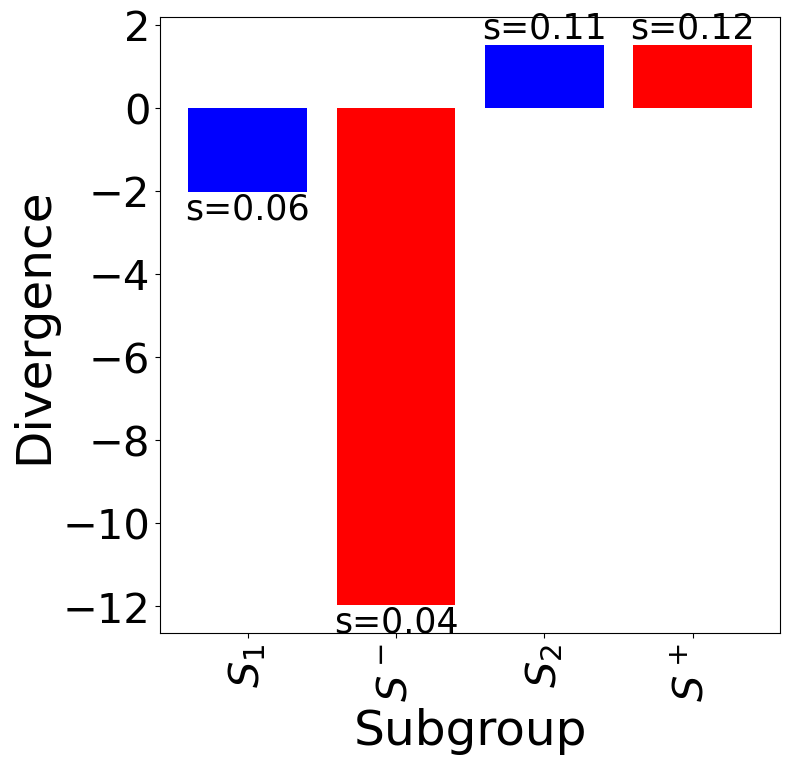

In [32]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("FSC, hub-l", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/FSC/fsc_baseline_hubert-large.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

# SLURP

## Define targets

In [33]:
## Target for DivExplorer: 
# 'prediction' is 1 if predicted_intet == original_intent, 0 otherwise
target_col = 'prediction' 
target_metric = 'd_posr'
target_div = 'd_accuracy'
t_value_col = 't_value_tp_fn'

In [34]:
## Columns for visualization
show_cols = ['support', 'itemsets', '#errors', '#corrects', 'accuracy', \
                'd_accuracy', 't_value', 'support_count', 'length']
remapped_cols = {'tn': '#errors', 'tp': '#corrects', 'posr': 'accuracy', \
                target_metric: target_div, 't_value_tp_fn': 't_value'}

In [35]:
## Columns of the df file that we are going to analyze 
demo_cols = ['gender', 'language', 'field']

slot_cols = ['scenario', 'action']

signal_cols = ['total_silence','total_duration', 'trimmed_duration', 
       'n_words', 'speed_rate_word', 'speed_rate_word_trimmed'] 

input_cols = demo_cols + slot_cols + signal_cols 

## Retrieve Data and Compute Divergence

In [36]:
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.FP_Divergence import FP_Divergence

In [37]:
configs = ["wav2vec2-base", "wav2vec2-large", "hubert-base", "hubert-large"]

FP_fm_dict = {}
fp_divergence_dict = {}
df_dict = {}

for config in configs:

    print(config)

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "SLURP", f"SLURP_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0)
    df[target_col] = df[target_col]

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )

    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)
    
    ## Create dict of Divergence df
    df_dict[config] = df_discretized

    fp_diver = FP_DivergenceExplorer(df_discretized, true_class_name = target_col, class_map={"P":1, "N":0})
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])

    FP_fm.rename(columns = remapped_cols, inplace = True)
    FP_fm = FP_fm[show_cols].copy()
    FP_fm['accuracy'] = round(FP_fm['accuracy'], 5)
    FP_fm['d_accuracy'] = round(FP_fm['d_accuracy'], 5)
    FP_fm['t_value'] = round(FP_fm['t_value'], 2)
    FP_fm_dict[config] = FP_fm
    fp_divergence_dict[config] = FP_Divergence(FP_fm, target_div)

wav2vec2-base
wav2vec2-large
hubert-base
hubert-large


In [38]:
## Compute the accuracy of the models
for config in configs:
    prediction = df_dict[config]['prediction'].sum()/len(df_dict[config])
    print(f"Accuracy of {config}:", round(100*prediction,3))
    print("----------")

Accuracy of wav2vec2-base: 86.863
----------
Accuracy of wav2vec2-large: 85.586
----------
Accuracy of hubert-base: 87.697
----------
Accuracy of hubert-large: 89.249
----------


In [39]:
W2V2_BASE_ACC = 86.86
W2V2_LARGE_ACC = 85.59
HUB_BASE_ACC = 87.70
HUB_LARGE_ACC = 89.25

## Divergence Wav2Vec2-Base

In [40]:
## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]

In [41]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
1721,action=quirky,0.05,67.367,-19.497,10.27
3873,"field=Far, scenario=general",0.03,68.020,-18.843,8.02
1174,scenario=general,0.06,71.921,-14.943,9.03


,itemsets,support,accuracy,d_accuracy,t_value
3085,"action=query, scenario=email",0.03,95.122,8.259,7.52
3877,"action=query, n_words=medium, tot_silence=medium",0.03,95.431,8.568,7.50
3889,"gender=Female, scenario=weather",0.03,95.929,9.065,8.32


,itemsets,support,accuracy,d_accuracy,t_value
1721,(action=quirky),0.05,67.367,-19.497,10.27


,itemsets,support,accuracy,d_accuracy,t_value
1444,(scenario=weather),0.05,94.428,7.565,7.97


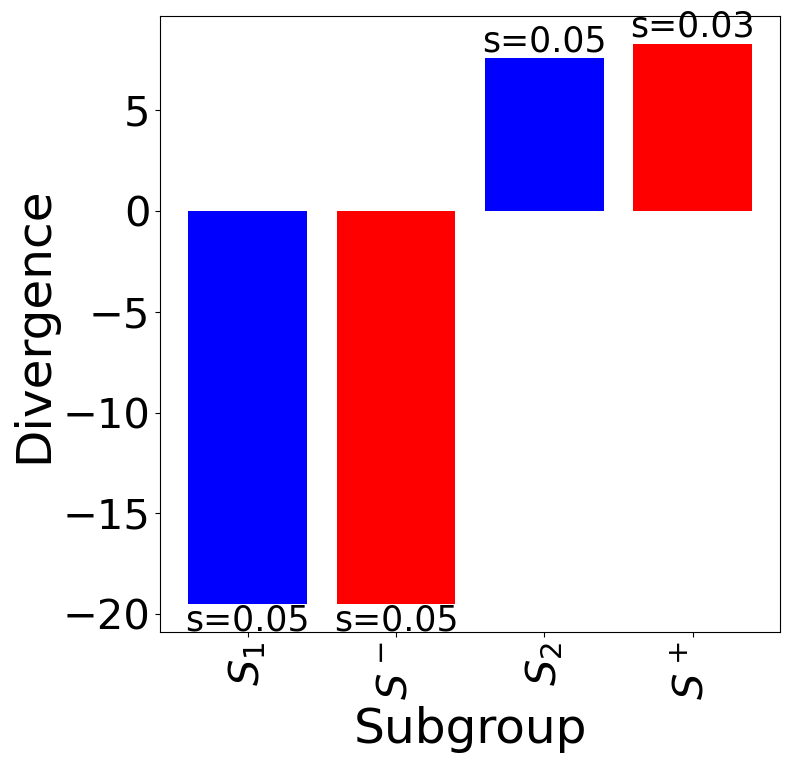

In [42]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("SLURP, w2v2-b", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/SLURP/slurp_baseline_wav2vec2-base.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence Wav2Vec2-Large

In [43]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [44]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
1721,action=quirky,0.05,68.174,-17.412,9.22
2723,"n_words=low, scenario=play, tot_dur=low, trim_dur=low",0.04,69.421,-16.165,7.69
2077,"n_words=low, scenario=play, trim_dur=low",0.04,70.304,-15.282,7.86


,itemsets,support,accuracy,d_accuracy,t_value
2527,"language=Other, scenario=email",0.04,94.433,8.847,8.04
2650,"field=Close, scenario=email",0.04,94.705,9.118,8.37
3085,"action=query, scenario=email",0.03,96.009,10.422,10.33


,itemsets,support,accuracy,d_accuracy,t_value
1721,(action=quirky),0.05,68.174,-17.412,9.22


,itemsets,support,accuracy,d_accuracy,t_value
1444,(scenario=weather),0.05,93.695,8.109,8.1


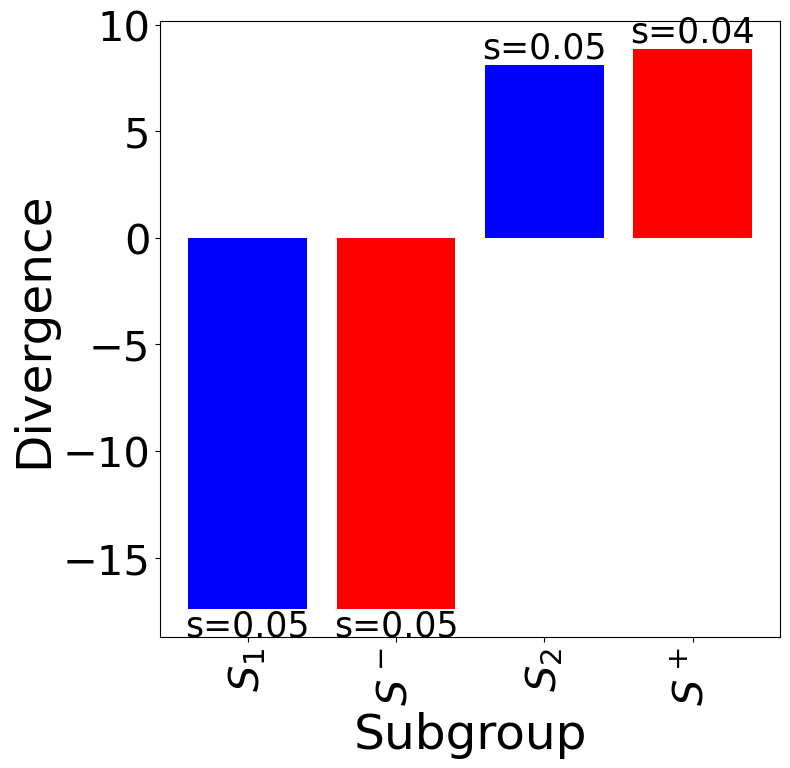

In [45]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("SLURP, w2v2-l", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/SLURP/slurp_baseline_wav2vec2-large.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence HuBERT-Base

In [46]:
## Compute the divergence for HuBERT base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [47]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
3873,"field=Far, scenario=general",0.03,66.497,-21.199,8.91
1721,action=quirky,0.05,67.205,-20.492,10.78
1174,scenario=general,0.06,71.391,-16.306,9.81


,itemsets,support,accuracy,d_accuracy,t_value
3555,"action=query, gender=Female, speakRate=low, tot_silence=medium",0.03,95.683,7.987,7.37
3733,"action=query, speakRate=low, speakRate_trim=low, trim_dur=medium",0.03,95.792,8.095,7.43
3634,"action=query, field=Close, gender=Female, trim_dur=medium",0.03,96.117,8.420,8.08


,itemsets,support,accuracy,d_accuracy,t_value
1721,(action=quirky),0.05,67.205,-20.492,10.78


,itemsets,support,accuracy,d_accuracy,t_value
1444,(scenario=weather),0.05,95.308,7.611,8.63


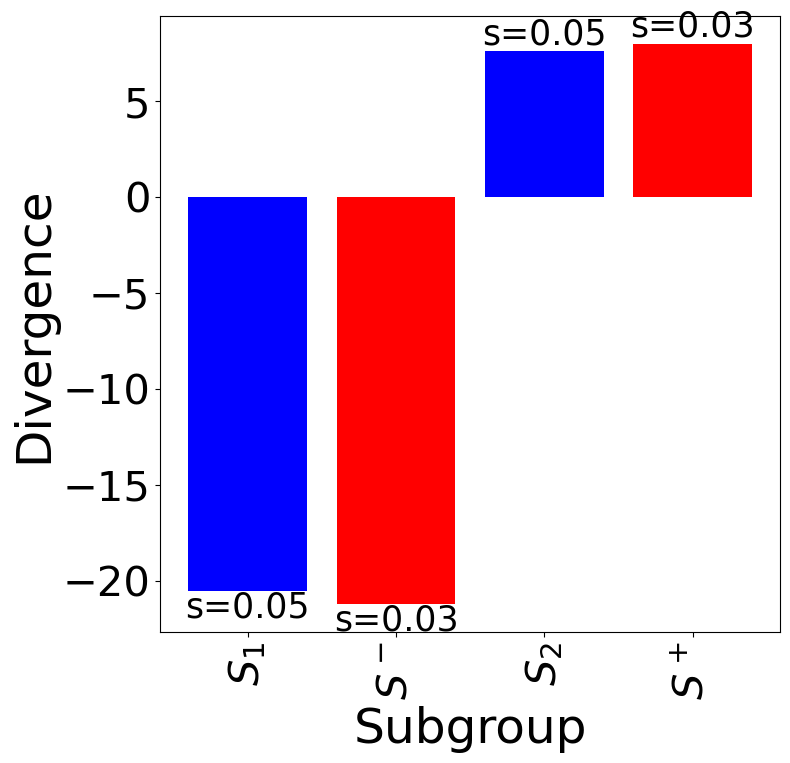

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("SLURP, hub-b", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/SLURP/slurp_baseline_hubert-base.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence HuBERT-Large

In [49]:
## Compute the divergence for HuBERT large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [50]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
2723,"n_words=low, scenario=play, tot_dur=low, trim_dur=low",0.04,77.273,-11.976,6.29
1721,action=quirky,0.05,77.706,-11.543,6.87
2077,"n_words=low, scenario=play, trim_dur=low",0.04,77.818,-11.432,6.49


,itemsets,support,accuracy,d_accuracy,t_value
3173,"action=set, n_words=high, scenario=calendar, trim_dur=high",0.03,96.614,7.365,7.77
3562,"field=Far, n_words=high, scenario=calendar",0.03,96.643,7.394,7.59
3889,"gender=Female, scenario=weather",0.03,96.947,7.697,7.97


,itemsets,support,accuracy,d_accuracy,t_value
1721,(action=quirky),0.05,77.706,-11.543,6.87


,itemsets,support,accuracy,d_accuracy,t_value
1398,(action=remove),0.05,95.514,6.265,7.3


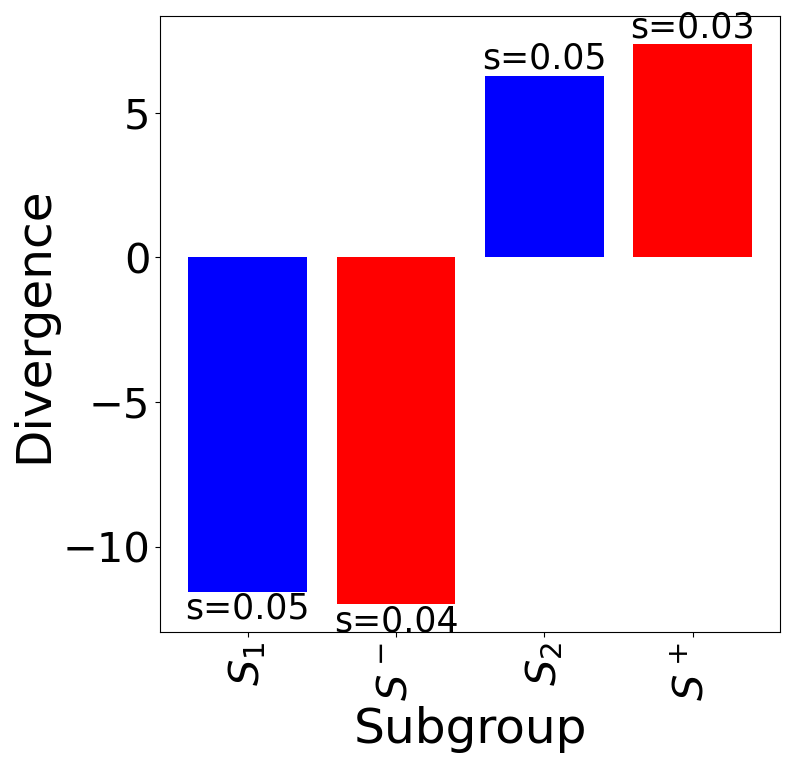

In [51]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("SLURP, hub-l", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/SLURP/slurp_baseline_hubert-large.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

# IEMOCAP

## Define targets

In [52]:
## Target for DivExplorer: 
# 'prediction' is 1 if predicted_intet == original_intent, 0 otherwise
target_col = 'prediction' 
target_metric = 'd_posr'
target_div = 'd_accuracy'
t_value_col = 't_value_tp_fn'

In [53]:
## Columns for visualization
show_cols = ['support', 'itemsets', '#errors', '#corrects', 'accuracy', \
                'd_accuracy', 't_value', 'support_count', 'length']
remapped_cols = {'tn': '#errors', 'tp': '#corrects', 'posr': 'accuracy', \
                target_metric: target_div, 't_value_tp_fn': 't_value'}

In [54]:
## Columns of the df file that we are going to analyze 
demo_cols = ['gender']

slot_cols = ['label']

signal_cols = ['total_silence', 'total_duration', 'trimmed_duration', 
       'n_words', 'speed_rate_word', 'speed_rate_word_trimmed',
       'valence', 'activation', 'dominance'] 

input_cols = demo_cols + slot_cols + signal_cols 

## Retrieve Data and Compute Divergence

In [55]:
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.FP_Divergence import FP_Divergence

In [56]:
configs = ["wav2vec2-base", "wav2vec2-large", "hubert-base", "hubert-large"]

FP_fm_dict = {}
fp_divergence_dict = {}
df_dict = {}

for config in configs:
    

    print(config)

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "IEMOCAP", f"IEMOCAP_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0)
    df[target_col] = df[target_col]

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )

    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)
    
    ## Create dict of Divergence df
    df_dict[config] = df_discretized

    fp_diver = FP_DivergenceExplorer(df_discretized, true_class_name = target_col, class_map={"P":1, "N":0})
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])

    FP_fm.rename(columns = remapped_cols, inplace = True)
    FP_fm = FP_fm[show_cols].copy()
    FP_fm['accuracy'] = round(FP_fm['accuracy'], 5)
    FP_fm['d_accuracy'] = round(FP_fm['d_accuracy'], 5)
    FP_fm['t_value'] = round(FP_fm['t_value'], 2)
    FP_fm_dict[config] = FP_fm
    fp_divergence_dict[config] = FP_Divergence(FP_fm, target_div)

wav2vec2-base
wav2vec2-large
hubert-base
hubert-large


In [57]:
## Compute the accuracy of the models
for config in configs:
    prediction = df_dict[config]['prediction'].sum()/len(df_dict[config])
    print(f"Accuracy of {config}:", round(100*prediction,3))
    print("----------")

Accuracy of wav2vec2-base: 74.655
----------
Accuracy of wav2vec2-large: 71.18
----------
Accuracy of hubert-base: 67.439
----------
Accuracy of hubert-large: 74.989
----------


In [58]:
W2V2_BASE_ACC = 74.655
W2V2_LARGE_ACC = 71.18
HUB_BASE_ACC = 67.439
HUB_LARGE_ACC = 74.989

## Divergence Wav2Vec2-Base

In [59]:
## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]

In [60]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
6289,"activation=low, label=hap",0.03,44.737,-29.918,7.37
7082,"activation=low, label=hap, valence=high",0.03,46.154,-28.501,6.81
4061,"label=hap, tot_silence=low",0.04,48.947,-25.707,7.02


,itemsets,support,accuracy,d_accuracy,t_value
7931,"activation=low, label=sad, tot_dur=high, tot_silence=low",0.03,98.519,23.864,16.49
7736,"gender=M, label=sad, tot_silence=low, trim_dur=high",0.03,98.529,23.875,16.60
7375,"label=sad, tot_silence=low, trim_dur=high, valence=low",0.03,98.571,23.917,17.01


,itemsets,support,accuracy,d_accuracy,t_value
254,(label=hap),0.13,64.034,-10.621,5.15


,itemsets,support,accuracy,d_accuracy,t_value
41,(label=sad),0.24,85.609,10.954,8.73


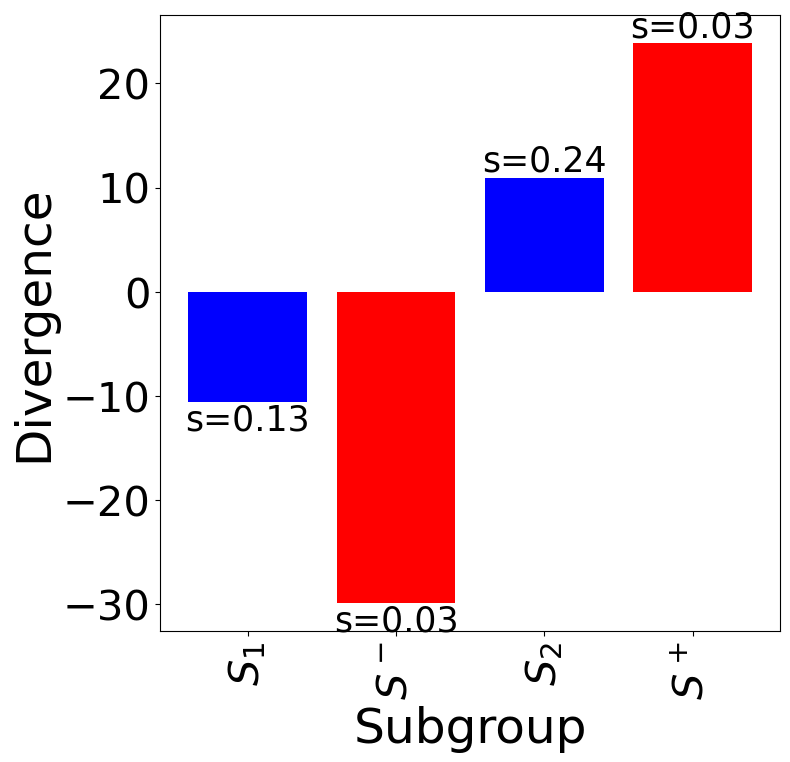

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("IEMOCAP, w2v2-b", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/IEMOCAP/iemocap_baseline_wav2vec2-base.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence Wav2Vec2-Large

In [62]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [63]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
4489,"label=hap, tot_silence=low, valence=high",0.04,41.436,-29.744,8.02
4061,"label=hap, tot_silence=low",0.04,41.579,-29.601,8.17
6289,"activation=low, label=hap",0.03,44.079,-27.101,6.68


,itemsets,support,accuracy,d_accuracy,t_value
7736,"gender=M, label=sad, tot_silence=low, trim_dur=high",0.03,94.853,23.673,11.00
7513,"activation=low, gender=M, label=sad, trim_dur=high",0.03,94.964,23.784,11.26
7375,"label=sad, tot_silence=low, trim_dur=high, valence=low",0.03,96.429,25.248,13.57


,itemsets,support,accuracy,d_accuracy,t_value
45,(valence=high),0.23,62.019,-9.161,5.57


,itemsets,support,accuracy,d_accuracy,t_value
41,(label=sad),0.24,77.214,6.034,4.16


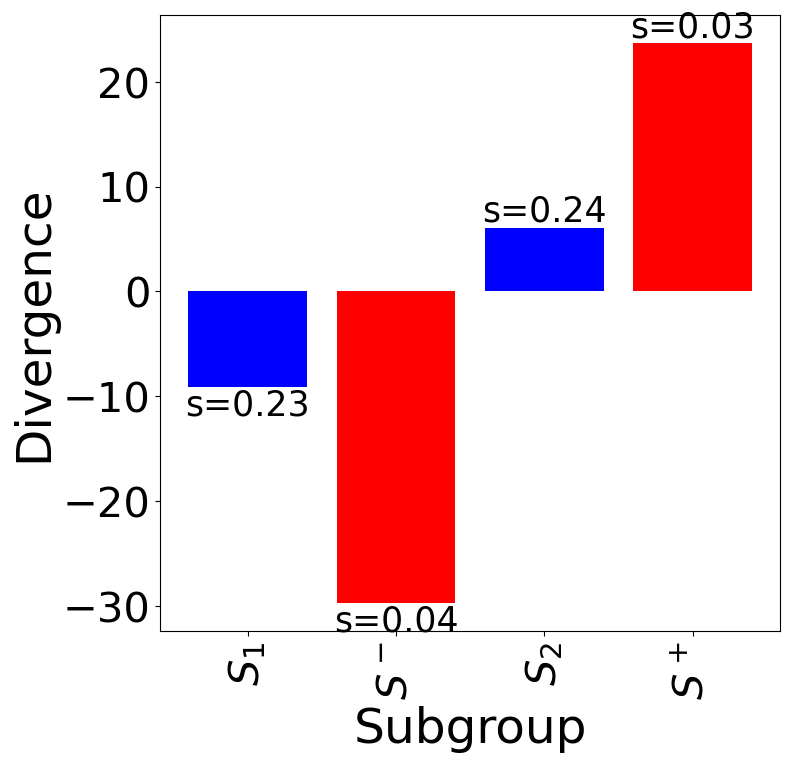

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("IEMOCAP, w2v2-l", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/IEMOCAP/iemocap_baseline_wav2vec2-large.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence HuBERT-Base

In [65]:
## Compute the divergence for HuBERT base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [66]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
4061,"label=hap, tot_silence=low",0.04,25.263,-42.176,13.04
4489,"label=hap, tot_silence=low, valence=high",0.04,25.414,-42.024,12.67
7082,"activation=low, label=hap, valence=high",0.03,26.573,-40.865,10.85


,itemsets,support,accuracy,d_accuracy,t_value
7736,"gender=M, label=sad, tot_silence=low, trim_dur=high",0.03,98.529,31.091,21.39
7248,"label=sad, speakRate_trim=high, tot_silence=low, trim_dur=high",0.03,98.582,31.143,22.02
5244,"activation=low, label=sad, tot_silence=low, trim_dur=high",0.04,99.401,31.962,28.93


,itemsets,support,accuracy,d_accuracy,t_value
254,(label=hap),0.13,53.613,-13.825,6.41


,itemsets,support,accuracy,d_accuracy,t_value
42,(dominance=high),0.24,77.06,9.621,6.54


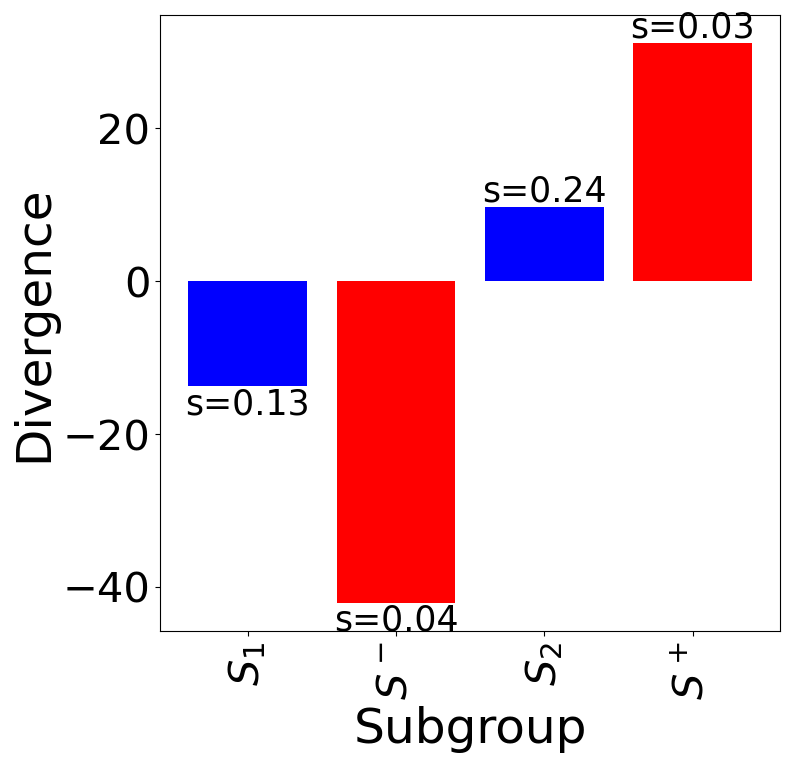

In [67]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("IEMOCAP, hub-b", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/IEMOCAP/iemocap_baseline_hubert-base.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence HuBERT-Large

In [68]:
## Compute the divergence for HuBERT large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [69]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["#errors"] = pr["#errors"].astype(int)
pr["#corrects"] = pr["#corrects"].astype(int)
pr["accuracy"] = (pr["accuracy"]*100).round(3)
pr["d_accuracy"] = (pr["d_accuracy"]*100).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].head(n).copy()
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head)

pr_l_tail = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].tail(n).copy()
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_tail)

pr_l_one = pr[[ "itemsets", "support", "accuracy", "d_accuracy", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_accuracy', ascending=True)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,accuracy,d_accuracy,t_value
4061,"label=hap, tot_silence=low",0.04,42.632,-32.357,8.92
6289,"activation=low, label=hap",0.03,43.421,-31.568,7.80
4489,"label=hap, tot_silence=low, valence=high",0.04,43.646,-31.342,8.42


,itemsets,support,accuracy,d_accuracy,t_value
7909,"activation=low, label=sad, n_words=high, tot_dur=high, trim_dur=high",0.03,97.778,22.789,14.06
7736,"gender=M, label=sad, tot_silence=low, trim_dur=high",0.03,97.794,22.805,14.16
7518,"activation=low, label=sad, n_words=high, trim_dur=high",0.03,97.842,22.853,14.45


,itemsets,support,accuracy,d_accuracy,t_value
45,(valence=high),0.23,65.0,-9.989,6.21


,itemsets,support,accuracy,d_accuracy,t_value
41,(label=sad),0.24,85.609,10.62,8.47


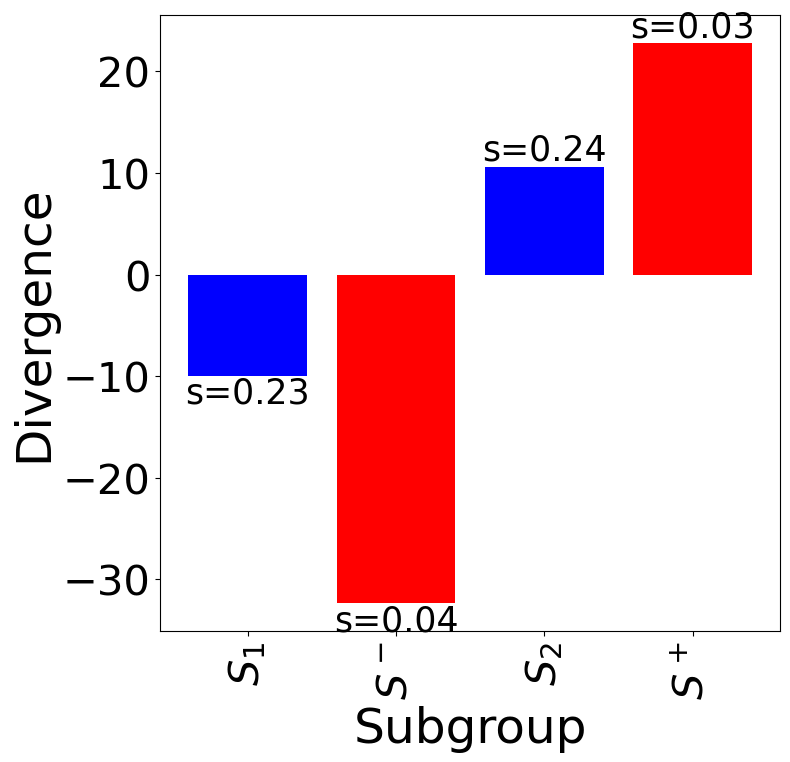

In [70]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_accuracy'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_accuracy'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_accuracy'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_accuracy'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("IEMOCAP, hub-l", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_accuracy'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='top')
plt.text(1, pr_l_head['d_accuracy'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='top')
plt.text(2, pr_l_one['d_accuracy'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='bottom')
plt.text(3, pr_l_tail['d_accuracy'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='bottom')

plt.savefig('plot_results/IEMOCAP/iemocap_baseline_hubert-large.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

# LibriSpeech

## Define targets

In [71]:
## Target for DivExplorer: 'WER'
target_col = 'WER' 
target_metric = 'd_outcome'
target_div = f'd_{target_col}'
t_value_col = 't_value_outcome'
printable_columns = ['support', 'itemsets','WER', 'd_WER', 't_value']

In [72]:
## Columns for visualization
remapped_cols = { "outcome": target_col, "d_outcome": target_div, t_value_col: 't_value'}
show_cols = ['support', 'itemsets', target_col, target_div, 'support_count', 'length', 't_value']

In [73]:
## Columns of the df file that we are going to analyze 
demo_cols = ['gender']

signal_cols = ['total_silence', 'total_duration', 'trimmed_duration', 
       'n_pauses', 'n_words', 'speed_rate_word', 'speed_rate_word_trimmed'] 

input_cols = demo_cols + signal_cols 

## Retrieve Data and Compute Divergence

In [74]:
from divexplorer.FP_DivergenceExplorer import FP_DivergenceExplorer
from divexplorer.FP_Divergence import FP_Divergence

In [75]:
configs = ["wav2vec2-base", "wav2vec2-large", "hubert-base", "hubert-large"]

FP_fm_dict = {}
fp_divergence_dict = {}
df_dict = {}

for config in configs:

    print(config)

    ## Read csv file
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "LibriSpeech", f"LibriSpeech_for_DivExplorer_{config}.csv") 

    df = pd.read_csv(input_file_divexplorer, index_col = 0)
    df[target_col] = df[target_col]

    ## Discretize the dataframe
    from util_discretization import discretize

    df_discretized = discretize(
        df[input_cols+[target_col]],
        bins=3,
        attributes=input_cols,
        strategy="quantile", 
        round_v = 2,
        min_distinct=5,
    )
    
    ## Replace values with ranges: "low", "medium", "high"
    replace_values = {}

    for i in range(0,len(signal_cols)):

        for v in df_discretized[signal_cols[i]].unique():
            if "<=" == v[0:2]:
                replace_values[v] = "low"
            elif ">" == v[0]:
                replace_values[v] = "high"
            elif "("  == v[0] and "]"  == v[-1]:
                replace_values[v] = "medium"
            else:
                raise ValueError(v)

        df_discretized[signal_cols[i]].replace(replace_values, inplace=True)
                
    ## Create dict of Divergence df
    df_dict[config] = df_discretized

    fp_diver = FP_DivergenceExplorer(df_discretized, target_name=target_col)
    FP_fm = fp_diver.getFrequentPatternDivergence(min_support=min_sup, metrics=[target_metric])
        
    FP_fm.rename(columns = remapped_cols, inplace = True)
    FP_fm = FP_fm[show_cols].copy()
    FP_fm['WER'] = round(FP_fm['WER'], 5)
    FP_fm['d_WER'] = round(FP_fm['d_WER'], 5)
    FP_fm['t_value'] = round(FP_fm['t_value'], 2)
    FP_fm_dict[config] = FP_fm
    fp_divergence_dict[config] = FP_Divergence(FP_fm, target_div)

wav2vec2-base
wav2vec2-large
hubert-base
hubert-large


In [76]:
## Compute WER for each config
from jiwer import wer

for config in configs:

    print(config)
    
    input_file_divexplorer = os.path.join(\
            os.getcwd(), "data_precomputed", "LibriSpeech", f"LibriSpeech_for_DivExplorer_{config}.csv") 
    df = pd.read_csv(input_file_divexplorer, index_col=0)
    df[target_col] = df[target_col]
    ground_truth = list(df['text'])
    hypothesis =list(df['transcription'])
    
    print((wer(ground_truth, hypothesis)*100))
    print("-------------")

wav2vec2-base
6.063603164942179
-------------
wav2vec2-large
3.815429093122337
-------------
hubert-base
6.558125380401704
-------------
hubert-large
3.495891661594644
-------------


In [77]:
WAV2VEC2_BASE_WER = 6.06
WAV2VEC2_LARGE_WER = 3.82
HUBERT_BASE_WER = 6.56
HUBERT_LARGE_WER = 3.50

## Divergence Wav2Vec2-Base

In [78]:
## Compute the divergence for Wav2Vec2-Base
config = 'wav2vec2-base'
fp_divergence_i = fp_divergence_dict[config]

In [79]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = ((pr["WER"] - WAV2VEC2_BASE_WER)).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l_head = pr_l_head.sort_values('d_WER', ascending=False)
pr_l_tail = pr_l_head.sort_values('d_WER', ascending=True)
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head.head(n))
display(pr_l_tail.head(n))

pr_l_one = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_WER', ascending=False)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,WER,d_WER,t_value
2410,"gender=F, n_pauses=low, speakRate_trim=high, trim_dur=low",0.03,17.298,11.238,4.16
2407,"gender=F, n_pauses=low, speakRate_trim=high, tot_dur=low",0.03,17.027,10.967,4.04
1909,"gender=F, speakRate=high, speakRate_trim=high, trim_dur=low",0.04,16.470,10.410,4.43


,itemsets,support,WER,d_WER,t_value
2099,"gender=F, n_pauses=low, speakRate=low, speakRate_trim=low, tot_dur=medium",0.03,3.274,-2.786,5.57
2104,"gender=F, n_pauses=low, speakRate=low, speakRate_trim=low, trim_dur=medium",0.03,3.315,-2.745,5.38
2009,"gender=F, n_pauses=low, speakRate_trim=low, trim_dur=medium",0.04,3.327,-2.733,5.54


,itemsets,support,WER,d_WER,t_value
5,(speed_rate_word=high),0.35,9.101,3.041,4.7


,itemsets,support,WER,d_WER,t_value
7,(speed_rate_word=low),0.35,4.694,-1.366,6.97


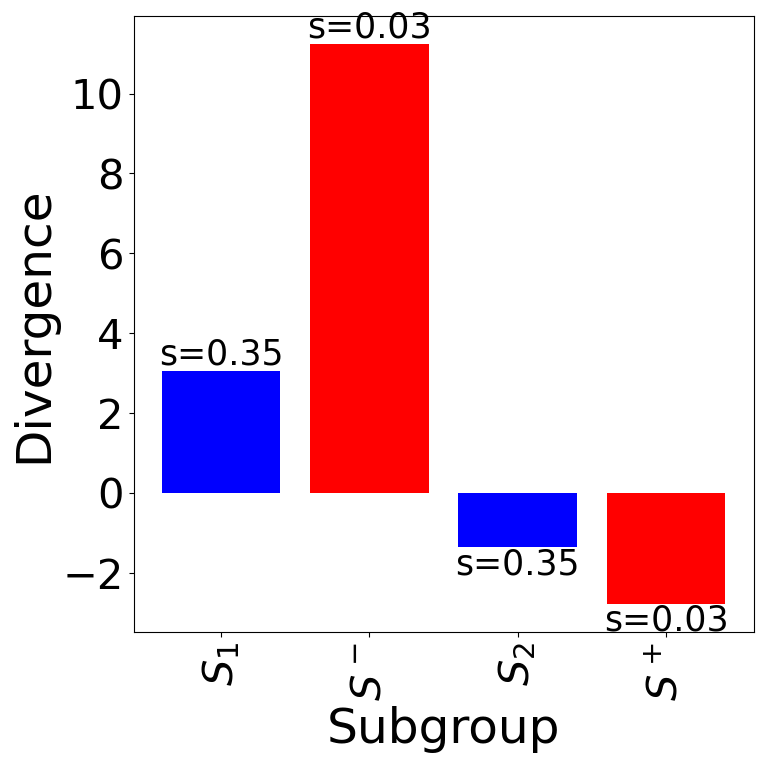

In [80]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_WER'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_WER'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_WER'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_WER'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("LibriSpeech, w2v2-b", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_WER'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='bottom')
plt.text(1, pr_l_head['d_WER'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='bottom')
plt.text(2, pr_l_one['d_WER'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='top')
plt.text(3, pr_l_tail['d_WER'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='top')

plt.savefig('plot_results/LibriSpeech/librispeech_baseline_wav2vec2-base.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence Wav2Vec2-Large

In [81]:
## Compute the divergence for Wav2Vec2-Large
config = 'wav2vec2-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [82]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = ((pr["WER"] - WAV2VEC2_LARGE_WER)).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l_head = pr_l_head.sort_values('d_WER', ascending=False)
pr_l_tail = pr_l_head.sort_values('d_WER', ascending=True)
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head.head(n))
display(pr_l_tail.head(n))

pr_l_one = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_WER', ascending=False)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,WER,d_WER,t_value
1484,"speakRate=high, speakRate_trim=high, tot_dur=low, tot_silence=low",0.05,12.559,8.739,3.53
1514,"speakRate=high, speakRate_trim=high, tot_dur=low, tot_silence=low, trim_dur=low",0.05,12.529,8.709,3.47
1482,"speakRate=high, speakRate_trim=high, tot_silence=low, trim_dur=low",0.05,12.404,8.584,3.47


,itemsets,support,WER,d_WER,t_value
2073,"gender=M, n_pauses=low, n_words=medium, speakRate=low",0.04,1.770,-2.050,6.79
1424,"gender=M, n_words=medium, speakRate=low",0.05,1.849,-1.971,7.24
1885,"gender=M, n_words=medium, speakRate=low, speakRate_trim=low",0.04,1.866,-1.954,6.80


,itemsets,support,WER,d_WER,t_value
5,(speed_rate_word=high),0.35,6.21,2.39,3.84


,itemsets,support,WER,d_WER,t_value
7,(speed_rate_word=low),0.35,3.185,-0.635,4.97


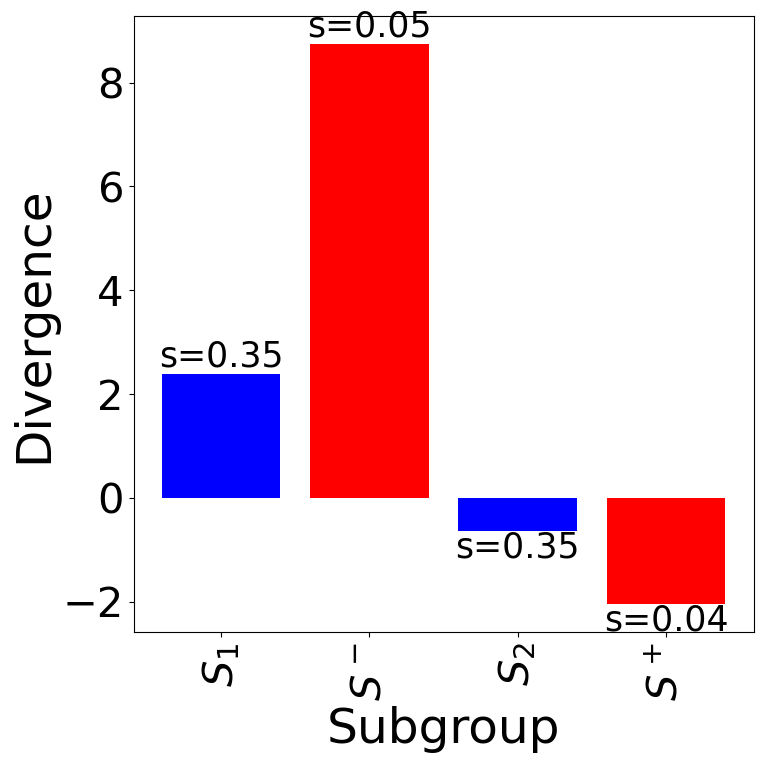

In [83]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_WER'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_WER'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_WER'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_WER'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("LibriSpeech, w2v2-l", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_WER'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='bottom')
plt.text(1, pr_l_head['d_WER'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='bottom')
plt.text(2, pr_l_one['d_WER'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='top')
plt.text(3, pr_l_tail['d_WER'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='top')

plt.savefig('plot_results/LibriSpeech/librispeech_baseline_wav2vec2-large.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence HuBERT-Base

In [84]:
## Compute the divergence for HuBERT base
config = 'hubert-base'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [85]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = ((pr["WER"] - HUBERT_BASE_WER)).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l_head = pr_l_head.sort_values('d_WER', ascending=False)
pr_l_tail = pr_l_head.sort_values('d_WER', ascending=True)
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head.head(n))
display(pr_l_tail.head(n))

pr_l_one = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_WER', ascending=False)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,WER,d_WER,t_value
2410,"gender=F, n_pauses=low, speakRate_trim=high, trim_dur=low",0.03,16.464,9.904,3.54
1909,"gender=F, speakRate=high, speakRate_trim=high, trim_dur=low",0.04,16.262,9.702,4.03
1886,"gender=F, speakRate_trim=high, trim_dur=low",0.04,16.211,9.651,4.04


,itemsets,support,WER,d_WER,t_value
1885,"gender=M, n_words=medium, speakRate=low, speakRate_trim=low",0.04,3.735,-2.825,7.18
2009,"gender=F, n_pauses=low, speakRate_trim=low, trim_dur=medium",0.04,3.764,-2.796,6.44
2192,"gender=M, n_words=medium, speakRate=low, speakRate_trim=low, trim_dur=medium",0.03,3.773,-2.787,6.43


,itemsets,support,WER,d_WER,t_value
5,(speed_rate_word=high),0.35,9.651,3.091,4.57


,itemsets,support,WER,d_WER,t_value
7,(speed_rate_word=low),0.35,5.585,-0.975,5.39


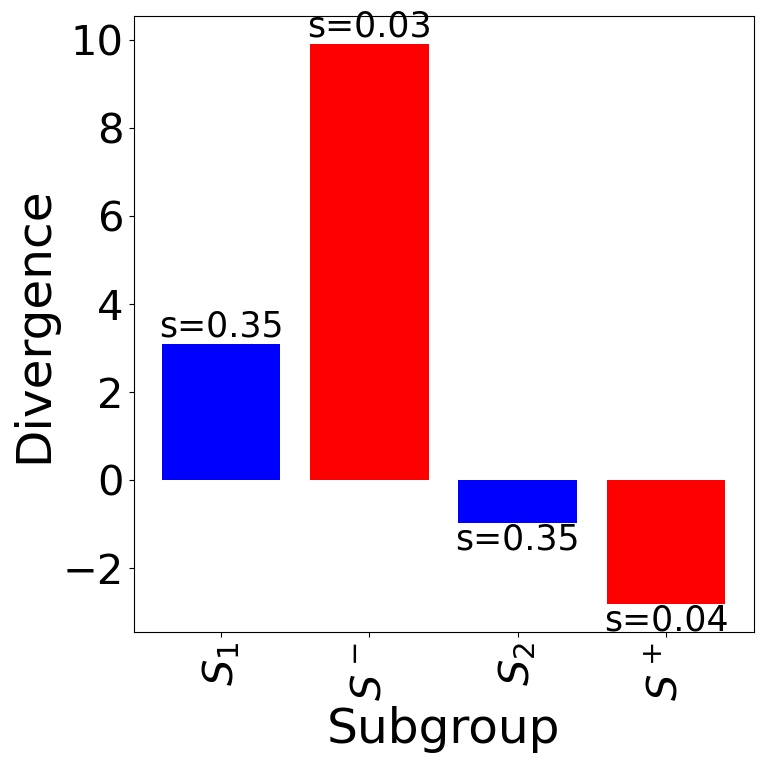

In [86]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_WER'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_WER'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_WER'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_WER'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("LibriSpeech, hub-b", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_WER'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='bottom')
plt.text(1, pr_l_head['d_WER'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='bottom')
plt.text(2, pr_l_one['d_WER'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='top')
plt.text(3, pr_l_tail['d_WER'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='top')

plt.savefig('plot_results/LibriSpeech/librispeech_baseline_hubert-base.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()

## Divergence HuBERT-Large

In [87]:
## Compute the divergence for HuBERT large
config = 'hubert-large'
fp_divergence_i = fp_divergence_dict[config]

FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 

In [88]:
from copy import deepcopy
n = 3

## Retrieve Most Negatively Divergent Itemsets 
FPdiv = fp_divergence_i.getDivergence(th_redundancy=0.0)[::-1] 
pr = FPdiv.copy()
pr["support"] = pr["support"].round(2)
pr["WER"] = (pr["WER"]*100).round(3)
pr["d_WER"] = ((pr["WER"] - HUBERT_LARGE_WER)).round(3)

## Choose columns for better visualization 
pr_l_head = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l_head = pr_l_head.sort_values('d_WER', ascending=False)
pr_l_tail = pr_l_head.sort_values('d_WER', ascending=True)
pr_l_head['itemsets'] = pr_l_head['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
pr_l_tail['itemsets'] = pr_l_tail['itemsets'].apply(lambda x: sortItemset(x, abbreviations))
display(pr_l_head.head(n))
display(pr_l_tail.head(n))

pr_l_one = pr[[ "itemsets", "support", "WER", "d_WER", "t_value"]].copy()
pr_l_one = pr_l_one[pr_l_one['itemsets'].apply(lambda x: len(x)==1)].copy()
pr_l_one = pr_l_one.sort_values('d_WER', ascending=False)
display(pr_l_one.head(1))
display(pr_l_one.tail(1))

,itemsets,support,WER,d_WER,t_value
2410,"gender=F, n_pauses=low, speakRate_trim=high, trim_dur=low",0.03,10.800,7.300,2.71
2407,"gender=F, n_pauses=low, speakRate_trim=high, tot_dur=low",0.03,10.782,7.282,2.69
928,"n_pauses=low, speakRate=high, speakRate_trim=high, tot_dur=low, trim_dur=low",0.06,10.383,6.883,3.76


,itemsets,support,WER,d_WER,t_value
2073,"gender=M, n_pauses=low, n_words=medium, speakRate=low",0.04,1.811,-1.689,5.99
1424,"gender=M, n_words=medium, speakRate=low",0.05,1.856,-1.644,6.47
2295,"gender=M, speakRate=low, speakRate_trim=low, tot_silence=medium",0.03,1.961,-1.539,5.09


,itemsets,support,WER,d_WER,t_value
5,(speed_rate_word=high),0.35,5.999,2.499,4.23


,itemsets,support,WER,d_WER,t_value
7,(speed_rate_word=low),0.35,2.849,-0.651,5.46


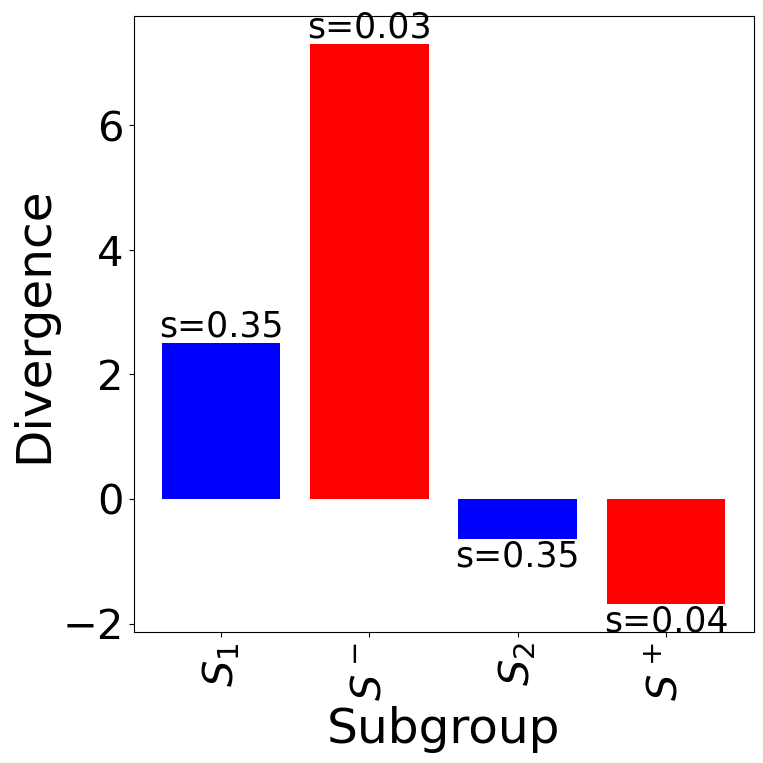

In [89]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
plt.rc('font', size=30)
plt.bar(r'$S_1$', \
    pr_l_one['d_WER'].values[0], color='blue')
plt.bar(r'$S^-$', \
    pr_l_head['d_WER'].values[0], color='red')
plt.bar(r'$S_2$', \
    pr_l_one['d_WER'].values[-1], color='blue')
plt.bar(r'$S^+$', \
    pr_l_tail['d_WER'].values[0], color='red')

plt.xlabel("Subgroup", fontsize=35)
plt.ylabel("Divergence", fontsize=35)
# plt.title("LibriSpeech, hub-l", fontsize=24)
plt.xticks(rotation=90)

supp_one_head = pr_l_one.support.values[0]
supp_one_tail = pr_l_one.support.values[-1]
supp_head = pr_l_head.support.values[0]
supp_tail = pr_l_tail.support.values[0]

plt.rc('font', size=25)
plt.text(0, pr_l_one['d_WER'].values[0]+0.01, \
    f"s={supp_one_head}", ha='center', va='bottom')
plt.text(1, pr_l_head['d_WER'].values[0]+0.01, \
    f"s={supp_head}", ha='center', va='bottom')
plt.text(2, pr_l_one['d_WER'].values[-1]+0.01, \
    f"s={supp_one_tail}", ha='center', va='top')
plt.text(3, pr_l_tail['d_WER'].values[0]+0.01, \
    f"s={supp_tail}", ha='center', va='top')

plt.savefig('plot_results/LibriSpeech/librispeech_baseline_hubert-large.pdf', 
    bbox_inches='tight', 
    facecolor="white", 
    transparent=False)
plt.show()